# Variable stars from the NASA K2 mission

[Kepler & K2](https://keplerscience.arc.nasa.gov) provide long-time-baseline, high-precision photometry for exoplanet and astrophysics research.

This Notebook contains code written and adapted by D. W. Hoard for processing, cleaning, performing time series analysis, and visualizing K2 time series data for variable stars.


## Workflow for processing K2 time series (light curve) data

I retrieved the raw \*\_llc.fits data files (e.g., ktwo212218649-c16_llc.fits) from the [MAST archive](https://mast.stsci.edu/). I have already pre-processed them into \*mast-kepconvert.txt data files (e.g., EPIC_212218649_sap_mast-kepconvert.txt) using the separate Python tasks k2sc and kepconvert. For completeness, the basic process for installing those packages and performing the pre-processing is decribed below.


## Pre-processing packages

This notebook uses the pre-processed data files as input. The pre-procesing is performed using two canned Python routines provided by the Kepler/K2 missions. Eventually, I will incorporate them into this workflow. For now, the pre-processing package installation and steps are described here.


### Documentation:

- K2SC
https://archive.stsci.edu/prepds/k2sc/


- KEPCONVERT
https://pyke.keplerscience.org/tasks/kepconvert.html


### Installation and use of the pre-processing packages

k2sc: Install from [GitHub](https://github.com/OxES/k2sc).

kepconvert: Installed as part of the [PyKE Python package](https://pyke.keplerscience.org/index.html)

If you have installed Anaconda, then k2sc and kepconvert can be installed as follows:
~~~~
# Install PyKE (for kepconvert)
pip install msgpack --upgrade
pip install argparse --upgrade
pip install pyketools --upgrade

# Install K2SC prerequisites:
pip install numpy --upgrade
pip install scipy --upgrade
pip install astropy --upgrade
pip install george --upgrade

# OPTIONAL (for parallelization):
pip install mpia4py --upgrade

# Install K2SC
cd ~/Applications/  # or installation directory of your choice; ensure that $DIRECTORY/k2sc/bin is in your PATH
git clone https://github.com/OxES/k2sc.git
cd k2sc
python setup.py install --user
~~~~

### Sample Python command line sequence for pre-processing of input data

~~~~
### Definitions  
# Target K2 (EPIC) ID number  
k2id='212218649'  
# Campaign number  
camid='16'  

### Automatically construct additional definitions
iname='ktwo'${k2id}'-c'${camid}
lcf=${iname}'_llc.fits'

### Run k2sc for SAP data
fltype='sap'
k2sc ${lcf} --campaign ${camid} --flux-type ${fltype} --logfile k2sc_${fltype}.log

### Export SAP light curve into ascii file
scf0='EPIC_'${k2id}'_mast.fits'
scf='EPIC_'${k2id}'_'${fltype}'_mast.fits'
mv ${scf0} ${scf}
kepconvert ${scf} fits2asc --columns TIME,CADENCE,QUALITY,X,Y,FLUX,ERROR,MFLAGS,TRTIME,TRPOSI --overwrite --verbose --logfile kepconvert_${fltype}.log

### Run k2sc for PDC data
fltype='pdc'
k2sc ${lcf} --campaign ${camid} --flux-type ${fltype} --logfile k2sc_${fltype}.log

### Export PDC light curve into ascii file
scf0='EPIC_'${k2id}'_mast.fits'
scf='EPIC_'${k2id}'_'${fltype}'_mast.fits'
mv ${scf0} ${scf}
kepconvert ${scf} fits2asc --columns TIME,CADENCE,QUALITY,X,Y,FLUX,ERROR,MFLAGS,TRTIME,TRPOSI --overwrite --verbose --logfile kepconvert_${fltype}.log
~~~~


## SAP vs. PDC data?

In short, using the SAP data is preferred for these purposes because some of the artifact removal applied in the PDC pipeline (which assumes that the stars are intrinsically non-variable, other than brief exoplanet transits) can remove actual variability from my targets-of-interest.

See https://keplerscience.arc.nasa.gov/pipeline.html


## Important note

The k2sc README file is wrong about output column contents. FLUX is a copy of the input (raw) flux, TRTIME is the time-dependent (variability) component of model, and TRPOSI is the position-dependent (systematics) component of model. The calculations performed below are correct.

---
# Import general purpose packages used throughout the workflow

In [1]:
import string
import time 
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


---
# Set global user-defined parameters
CUSTOMIZE ANY OF THESE AS NEEDED!!!

In [2]:
###############################################
# TARGET AND DATA IDENTIFIERS
# list of unique target identifier string(s)
tname = ['212218649', '212213538', '212211859', '212222400']
# index of target identifier to use (starts at zero)
tidx = 0

# K2 campaign id number (used to define default covariance matrix split values for plotting)
# (-1 = do not use)
#k2camid = -1
k2camid = 16

# select the input data type (SAP or PDC) - see note above
dtype = 'sap'
#dtype = 'pdc'

# GENERAL CONFIGURATION
# path for saving output files
SAVEPATH = './output/'

# verbosity level of debugging/info comments
# (-1 = none, 0 = crucial only, 1 = some, 2 = all)
LDEBUG = 1
###############################################


---
# Set global default parameters
ALMOST NEVER NEED TO CHANGE THESE!!!

In [12]:
# define part of the output file names base don target identifier and data type
name_string = tname[tidx]+'_'+dtype

# default dimensions for visualization output files, if not specified in individual "fig" setups (inches)
#PSIZE_DEFAULT = (12,6)
#PSIZE_DEFAULT = (10,6)
PSIZE_DEFAULT = (9,6)
plt.rcParams["figure.figsize"] = PSIZE_DEFAULT

# optional addition to input path if non-variable "check" data is stored in a separate directory
import os.path
INPUTPATH = ''
if tidx > 0 and os.path.exists('nearby_stars'):
    INPUTPATH = 'nearby_stars/ktwo'+tname[tidx]+'/'
                             
# fontsize for (1) tick labels, (2) axis labels
size_sm = '14'
size_md = '16'
size_lg = '18'

# K2 start time
t0 = 2454833.0

# make array of alphabet letters for general use later
abclabels = list(string.ascii_lowercase)


---
# Define global functions

In [4]:
# convert file counter to string for creating output file names
def strfcount(fcount):
    sfcount = str(fcount)
    if fcount < 10:
        sfcount = '0'+sfcount
    return sfcount

# normalize series to itself and convert to %
def norm_self(x):
    return 100*(x/np.median(x) - 1.0)

# normalize series to another number and convert to %
def norm_other(x,y):
    return 100*(x/y - 1.0)

# truncate a number to keep only the decimal part (used with phase calculations)
def mphi(p):
    return p-int(p)

# calculate axis limits for plotting edge-to-edge lines
# expected input:
#   r = 2-element series with [min, max] axis limits
#   m = ax.margins()[i] where i = 0 for x axis, 1 for y-axis
def axis_limits(r, m):
    diff = m*(r[1]-r[0])
    return [r[0]-diff, r[1]+diff]

# create a timestamp of the current date and time
def timestamp():
    ts = time.localtime()
    return time.strftime("%Y-%m-%d %H:%M:%S", ts)

# track runtime
# declare start = time.time() before start of process of interest, then invoke time_since(start) at end
def time_since(since):
    now = time.time()
    s = now - since
    h = np.floor(s / 3600)
    s -= h * 3600
    m = np.floor(s / 60)
    s -= m * 60
    return '%dh %dm %ds' % (h, m, s)


---
# Initialize log file

In [5]:
# create logfile
logfile_name = SAVEPATH+name_string+'_k2timeseries.log'
logfile_out = open(logfile_name, 'w')

# write initial log file entries
print(timestamp(), file=logfile_out)
print('### PARAMETERS ###', file=logfile_out)
print('[user] target index (tidx) =',tidx, file=logfile_out)
print('[user] target ID (tname[tidx]) =',tname[tidx], file=logfile_out)
print('[user] K2 campaign ID (k2camid) =',k2camid, file=logfile_out)
print('[user] data type (dtype) =',dtype, file=logfile_out)
print('[user] output file path (SAVEPATH) =',SAVEPATH, file=logfile_out)
print('[user] debug comments level (LDEBUG) =',LDEBUG, file=logfile_out)
print('[user] K2 start time (t0) =',t0, file=logfile_out)
print('name string (name_string) =',name_string,'\n', file=logfile_out)
logfile_out.close()


---
# Read unfolded ("raw") light curve data into a DataFrame; clean data

In [6]:
# create file handler in read mode 
file_handler = open(INPUTPATH+"EPIC_"+name_string+"_mast-kepconvert.txt", "r") 

# define column names and convert data to DataFrame
dfcols  = ['time', 'cadence', 'quality', 'xpos', 'ypos', 'rawflux', 'fluxerr', 'mflags', 'trtime', 'trposi']
df_lc = ( pd.read_csv(file_handler, sep=' ', usecols=(0,1,2,3,4,5,6,7,8,9), header=None, skiprows=1, names=dfcols, comment='#',
        dtype={dfcols[0]:'float64',dfcols[1]:'int64',dfcols[2]:'int64',dfcols[3]:'float64',dfcols[4]:'float64',
        dfcols[5]:'float64',dfcols[6]:'float64',dfcols[7]:'int64',dfcols[8]:'float64',dfcols[9]:'float64'}) )

# close the file handler 
file_handler.close() 

# remove rows with NaNs in important columns
df_lc.dropna(subset=['time', 'rawflux', 'fluxerr'], inplace=True)

# trtime = time-dependent (variability) component of K2SC model
# trposi = position-dependent (systematics) component of K2SC model

# this is the raw flux with position-dependent artifacts removed (i.e., time-dependent variability only)
df_lc['varflux'] = df_lc['rawflux'] - df_lc['trposi'] + np.mean(df_lc['trposi'])

# this is the raw flux with time variability removed (i.e., only position-dependent variability is present)
df_lc['posflux'] = df_lc['rawflux'] - df_lc['trtime'] + np.mean(df_lc['trtime'])

# this is the residual flux with both components removed
df_lc['resflux'] = df_lc['rawflux'] - df_lc['trtime'] + np.mean(df_lc['trtime']) - df_lc['trposi'] + np.mean(df_lc['trposi'])

# calulate Kepler magnitude from time variability series (2016AJ....152....5D)
df_lc['kp2mag'] = 12.0 + (np.log10(df_lc['varflux']/1.74e5) / (-0.4))

# remove rows with poor Quality values or masked values (bad values defined in K2 documentation)
df_lc_clean = df_lc[(df_lc.quality < 2.0**19) & (df_lc.mflags == 0)].copy()
df_lc_dirty_only = df_lc[(df_lc.quality >= 2.0**19) | (df_lc.mflags > 0)].copy()

message2a = 'Number of raw data points: '+str(len(df_lc['varflux']))
message2b = 'Number of cleaned data points: '+str(len(df_lc_clean))
message2c = 'Number of rejected data points: '+str(len(df_lc_dirty_only))
message2d = 'Fraction of rejected data points (%): '+str(round(100*len(df_lc_dirty_only)/len(df_lc['varflux']),3))
message2e = 'Number of summed data points: '+str(len(df_lc_clean)+len(df_lc_dirty_only))+' (should be the same as raw number)'
print(message2a)
print(message2b)
print(message2c)
print(message2d)
print(message2e+'\n')

# write logfile entry
logfile_out = open(logfile_name, 'a+')
print(timestamp(), file=logfile_out)
print('### READ AND CLEAN DATA ###', file=logfile_out)
print(message2a, file=logfile_out)
print(message2b, file=logfile_out)
print(message2c, file=logfile_out)
print(message2d, file=logfile_out)
print(message2e, file=logfile_out)
message1 = '*** Finished loading and cleaning input data'
print(message1,'\n', file=logfile_out)
logfile_out.close()

# end this section gracefully
if LDEBUG >=2: 
    pd.options.display.float_format = '{:f}'.format
    print(df_lc_clean)
    print(df_lc_dirty_only)
if LDEBUG >=0: print(message1)


Number of raw data points: 3807
Number of cleaned data points: 3572
Number of rejected data points: 235
Fraction of rejected data points (%): 6.173
Number of summed data points: 3807 (should be the same as raw number)

*** Finished loading and cleaning input data


---
# Reference: K2 data flags
From the [Kepler Archive Manual](https://archive.stsci.edu/kepler/manuals/archive_manual.pdf) (KDMC-10008-006), written by Susan E. Thompson, Dorothy Fraquelli, Jeffrey E. van Cleve and Douglas A. Caldwell (2 May 2016)

|Table 2-3: Bits for the QUALITY and SAP_QUALITY data column|
|:---:|

Bit    | Value    | <p>Explanation</p>
:-----:|---------:|----------------------
 1*    |       1  | <p>Attitude Tweak</p>
 2*    |       2  | <p>Safe Mode</p>
 3*    |       4  | <p>Spacecraft is in coarse point. It is set manually<br>to pad not-in-fine point data.</p>
 4*    |       8  | <p>Spacecraft is in Earth point. The first real<br>cadence after Earth point is marked.</p>
 5     |      16  | <p>Reaction wheel zero crossing</p>
 6*    |      32  | <p>Reaction wheel desaturation event</p>
 7*    |      64  | <p>Argabrightening detected across multiple<br>channels on this cadence</p>
 8     |     128  | <p>Cosmic Ray was found and corrected in<br>optimal aperture pixel</p>
 9*    |     256  | <p>Manual Exclude. The cadence was excluded<br>because of an anomaly.</p>
10     |     512  | <p>This bit is unused by Kepler.</p>
11     |    1024  | <p>SPSD detected. This bit is flagged on the last<br>non-gapped cadence before the maximum<br>positive change due to the detected SPSD.</p>
12     |    2048  | <p>Impulsive outlier removed before cotrending</p>
13*    |    4096  | <p>Argabrightening event on specified CCD<br>mod/out detected</p>
14     |    8192  | <p>Cosmic Ray detected on collateral pixel<br>row or column in optimal aperture.</p>
15*    |   16384  | <p>Detector anomaly flag was raised.</p>
16*    |   32768  | <p>Spacecraft is not in fine point.</p>
17*    |   65536  | <p>No data collected.</p>
18     |  131072  | <p>Rolling Band detected in optimal aperture.</p>
19     |  262144  | <p>Rolling Band detected in full mask.</p>
20     |  545288  | <p>Possible thruster firing. Not set in Kepler data</p>
21     | 1048576  | <p>Thruster firing. Not set in Kepler data.</p>
&nbsp; | &nbsp;   | <p>\* indicates that these cadences are gapped<br>by the pipeline (either in CAL, PA or PDC).<br>The original pixel level data is available in<br>most cases.</p>


|K2SC Masking Flags|
|:---:|

Value       | <p>Explanation</p>
------------|------------
2\*\*0  (1) | <p>one of the K2 quality flags on</p>
2\*\*1  (2) | <p>flare (reserved but not currently used)</p> 
2\*\*2  (4) | <p>transit (reserved but not currently used)</p>
2\*\*3  (8) | <p>upwards outlier</p>
2\*\*4 (16) | <p>downwards outlier</p>
2\*\*5 (32) | <p>nonfinite flux</p>
2\*\*6 (64) | <p>a periodic mask applied manually by k2sc (not used)</p>

---
# Visualize the raw and cleaned input data

Panel 0: pyrange = [-1.7473528385162351, 0.5674715638160704]
Panel 1: pyrange = [28.30378723144531, 457.48587036132807]
Panel 2: pyrange = [3.37083389238191, 376.584310175082]
Panel 3: pyrange = [-46.24915594443384, 112.00551985661322]
Panel 4: pyrange = [-46.24915594443384, 112.00551985661322]
Panel 5: pyrange = [18.625465955647986, 20.11537065593896]

 *** Finished visualizing the raw and processed input data


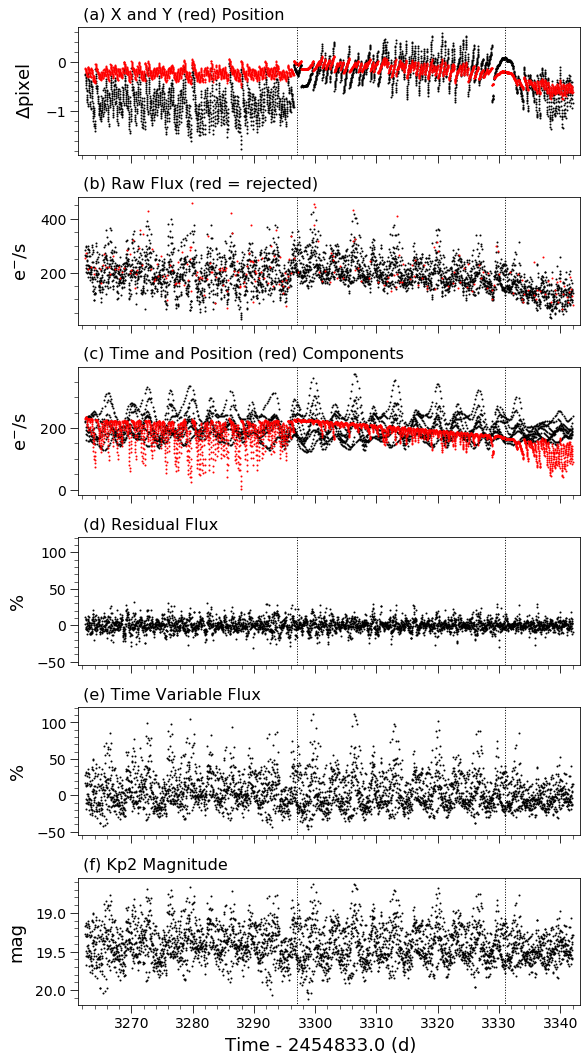

In [44]:
###############################################
# CUSTOMIZE ANY OF THESE AS NEEDED!!!

# These are the y-axis range values set for the variable star, for use with nearby comparison stars
pyrange_ref = [ [-1.7473528385162351, 0.5674715638160704],
                [28.30378723144531, 457.48587036132807],
                [3.37083389238191, 376.584310175082],
                [-46.24915594443384, 112.00551985661322],
                [-46.24915594443384, 112.00551985661322],
                [18.625465955647986, 20.11537065593896] ]

#USE_PYRANGE_REF = False
USE_PYRANGE_REF = True

# fraction of total range for expanding x-axis endpoints when plotting
rangefac_x = 0.015

# fraction of total range for expanding y-axis endpoints when plotting
rangefac_y = 0.055
###############################################

fcount = 1 # increment output file counter

# define default covariance matrix split values (corresponding to roll angle reversals) for plotting
# (these times are relative to t0)
if k2camid > 0:
    splits = {
        3:[2154,2190],
        4:[2240,2273],
        5:[2344],
        6:[2390,2428],
        7:[2468.5,2515],
        8:[2579,2598],
        10:[2772,2800],
        12:[2916,2949],
        13:[2997,3032],
        14:[3086.4,3123.65],
        16:[3297,3331]
    }
    if k2camid not in splits:
        print('*** WARNING: splits for campaign '+str(k2camid)+' not defined - ignoring')

# set up the multipanel plot
npanels=6
#fig, axes = plt.subplots(npanels, 1, figsize=(10,npanels*3), sharex=True)
fig, axes = plt.subplots(npanels, 1, figsize=(9,npanels*3), sharex=True)

# position of subplot panel titles in axis coordinates (x, y)
labelpos = (0.0, 1.10)

# write logfile
logfile_out = open(logfile_name, 'a+')
print(timestamp(), file=logfile_out)
print('### INPUT DATA VISUALIZATION ###', file=logfile_out)
print('[user] fraction of total range for x-axis margins (rangefac_x):',rangefac_x, file=logfile_out)
print('[user] fraction of total range for y-axis margins (rangefac_y):',rangefac_y, file=logfile_out)
print('[user] using K2 campaign splits? (USE_PYRANGE_REF) =',USE_PYRANGE_REF, file=logfile_out)
if tidx > 0 and USE_PYRANGE_REF == True:
    print('Reference y-axis ranges for panels 0-'+str(npanels-1)+' (pyrange_ref):', file=logfile_out)
    for i, item in enumerate(pyrange_ref): print('Panel '+str(i)+': pyrange = '+str(item), file=logfile_out)
print('Plotted y-axis ranges for panels 0-'+str(npanels-1)+' (pyrange ):', file=logfile_out)

# centered common axis labels
fig.text(0.5, 0.09, 'Time - '+str(t0)+' (d)', ha='center', size=size_lg)

# change amount of padding between subplot panels
fig.subplots_adjust(wspace=0, hspace=0.33)

# function for calculating y-axis plotting range
def pyrange_calc(y1, y2, rangefac_y):
    pyrange_temp = [min(y1), max(y2)]
    #pyrange_temp = [pyrange_temp[0]-rangefac_y*abs(pyrange_temp[0]-pyrange_temp[1]), pyrange_temp[1]+rangefac_y*abs(pyrange_temp[0]-pyrange_temp[1])]
    return pyrange_temp
            
# loop over panels
pyrange=[0,0]
ylpad = 10   # padding for y-axis labels (in points)
for i, ax in enumerate(axes.flatten()):
    if LDEBUG >= 2: print(i, ax)
    
    ax.tick_params(labelsize=size_sm)
    ax.margins(x=rangefac_x)
    ax.margins(y=rangefac_y)

    # Position
    if i == npanels-6:
        pyrange_temp = pyrange_calc([min(df_lc.xpos),min(df_lc.ypos)], [max(df_lc.xpos),max(df_lc.xpos)], rangefac_y)
        if tidx > 0 and USE_PYRANGE_REF == True:
            pyrange = [(j - np.mean(pyrange_ref[i]) + np.mean(pyrange_temp)) for j in pyrange_ref[i]]
        else:
            pyrange = pyrange_temp
        #ax.set_ylim(pyrange)
        ax.plot(df_lc_clean.time-t0,df_lc_clean.xpos, 'k.', markersize=2)
        ax.plot(df_lc_clean.time-t0,df_lc_clean.ypos, 'r.', markersize=2)
        ax.set_ylabel('$\Delta$pixel', size=size_lg, labelpad=ylpad)
        ax.annotate(' (a) X and Y (red) Position', size=size_md, 
            xy=labelpos, xycoords='axes fraction',
            horizontalalignment='left', verticalalignment='center')
    
    # Raw Flux
    if i == npanels-5:
        #pyrange_temp = [min(df_lc.rawflux), max(df_lc.rawflux)]
        pyrange_temp = pyrange_calc(df_lc.rawflux, df_lc.rawflux, rangefac_y)
        if tidx > 0 and USE_PYRANGE_REF == True:
            pyrange = [(j - np.mean(pyrange_ref[i]) + np.mean(pyrange_temp)) for j in pyrange_ref[i]]
        else:
            pyrange = pyrange_temp
        #ax.set_ylim(pyrange)
        ax.plot(df_lc_clean.time-t0,df_lc_clean.rawflux, 'k.', markersize=2)
        ax.plot(df_lc_dirty_only.time-t0,df_lc_dirty_only.rawflux, 'r.', markersize=2)
        ax.set_ylabel('e$^{-}$/s', size=size_lg, labelpad=ylpad)
        ax.annotate(' (b) Raw Flux (red = rejected)', size=size_md, 
            xy=labelpos, xycoords='axes fraction',
            horizontalalignment='left', verticalalignment='center')

    # Variability Components
    if i == npanels-4:
        #pyrange_temp = [min([min(df_lc_clean.trtime),min(df_lc_clean.trposi)]), max([max(df_lc_clean.trtime),max(df_lc_clean.trposi)])]
        pyrange_temp = pyrange_calc([min(df_lc_clean.trtime),min(df_lc_clean.trposi)], [max(df_lc_clean.trtime),max(df_lc_clean.trposi)], rangefac_y)
        if tidx > 0 and USE_PYRANGE_REF == True:
            pyrange = [(j - np.mean(pyrange_ref[i]) + np.mean(pyrange_temp)) for j in pyrange_ref[i]]
        else:
            pyrange = pyrange_temp
        #ax.set_ylim(pyrange)
        ax.plot(df_lc_clean.time-t0,df_lc_clean.trtime, 'k.', markersize=2)
        ax.plot(df_lc_clean.time-t0,df_lc_clean.trposi, 'r.', markersize=2)
        ax.set_ylabel('e$^{-}$/s', size=size_lg, labelpad=ylpad)
        ax.annotate(' (c) Time and Position (red) Components', size=size_md, 
            xy=labelpos, xycoords='axes fraction',
            horizontalalignment='left', verticalalignment='center')

    # Residual Flux
    if i == npanels-3:
        #pyrange_temp = [min(norm_self(df_lc_clean.varflux)), max(norm_self(df_lc_clean.varflux))]
        pyrange_temp = pyrange_calc(norm_self(df_lc_clean.varflux), norm_self(df_lc_clean.varflux), rangefac_y)
        if tidx > 0 and USE_PYRANGE_REF == True:
            pyrange = [(j - np.mean(pyrange_ref[i]) + np.mean(pyrange_temp)) for j in pyrange_ref[i]]
        else:
            pyrange = pyrange_temp
        #ax.set_ylim(pyrange)
        ax.plot(df_lc_clean.time-t0, norm_self(df_lc_clean.resflux), 'k.', markersize=2)
        ax.set_ylabel('%', size=size_lg, labelpad=ylpad)
        ax.annotate(' (d) Residual Flux', size=size_md, 
            xy=labelpos, xycoords='axes fraction',
            horizontalalignment='left', verticalalignment='center')

    # Time Variable Flux
    if i == npanels-2:
        #pyrange_temp = [min(norm_self(df_lc_clean.varflux)), max(norm_self(df_lc_clean.varflux))]
        pyrange_temp = pyrange_calc(norm_self(df_lc_clean.varflux), norm_self(df_lc_clean.varflux), rangefac_y)
        if tidx > 0 and USE_PYRANGE_REF == True:
            pyrange = [(j - np.mean(pyrange_ref[i]) + np.mean(pyrange_temp)) for j in pyrange_ref[i]]
        else:
            pyrange = pyrange_temp
        #ax.set_ylim(pyrange)
        ax.plot(df_lc_clean.time-t0, norm_self(df_lc_clean.varflux), 'k.', markersize=2)
        ax.set_ylabel('%', size=size_lg, labelpad=ylpad)
        ax.annotate(' (e) Time Variable Flux', size=size_md, 
            xy=labelpos, xycoords='axes fraction',
            horizontalalignment='left', verticalalignment='center')

    # Time Variable Flux as Kp2 magnitudes
    if i == npanels-1:
        #pyrange_temp = [max(df_lc_clean.kp2mag), min(df_lc_clean.kp2mag)]
        pyrange_temp = pyrange_calc(df_lc_clean.kp2mag, df_lc_clean.kp2mag, rangefac_y)
        if tidx > 0 and USE_PYRANGE_REF == True:
            pyrange = [(j - np.mean(pyrange_ref[i]) + np.mean(pyrange_temp)) for j in pyrange_ref[i]]
        else:
            pyrange = pyrange_temp
        #ax.set_ylim(pyrange)
        ax.plot(df_lc_clean.time-t0, df_lc_clean.kp2mag, 'k.', markersize=2)
        ax.invert_yaxis()
        ax.set_ylabel('mag', size=size_lg, labelpad=ylpad)
        ax.annotate(' (f) Kp2 Magnitude', size=size_md, 
            xy=labelpos, xycoords='axes fraction',
            horizontalalignment='left', verticalalignment='center')
        
    # plot decorations (apply to all subplot panels)
    # mark covariance matrix splits with a line that spans subplot box limits without padding
    if k2camid in splits:
        old_ax_margins = ax.margins()
        for j in splits[k2camid]:
            ax.margins(y=0)
            ax.plot([j,j], axis_limits(pyrange,old_ax_margins[1]), 'k:', linewidth=1)
    
    message1 = 'Panel '+str(i)+': pyrange = '+str(pyrange)
    print(message1)
    print(message1, file=logfile_out)
    
    # turn on minor tick marks
    ax.minorticks_on()
    
    # properties of tick marks
    ax.tick_params(which='major', direction='out', length=8, bottom=True, top=False, left=True, right=False)
    ax.tick_params(which='minor', direction='out', length=4, bottom=True, top=False, left=True, right=False)
    
# output the visualization
plt.savefig(SAVEPATH+name_string+'_'+strfcount(fcount)+'_input_data.png',dpi=150, bbox_inches='tight')

# finish logfile entry
message2 = '*** Finished visualizing the raw and processed input data'
print(message2,'\n', file=logfile_out)
logfile_out.close()

# end this section gracefully
if LDEBUG >= 0: print('\n',message2)


---
# Set up for Lomb-Scargle periodogram calculation

In [8]:
###############################################
# CUSTOMIZE ANY OF THESE AS NEEDED!!!

# override automatic calculation of maximum frequency
# (use -1 to ignore this setting)
user_fmax = -1
###############################################

# slice out the periodogram input data
x = df_lc_clean.time.to_numpy(copy=True)
N = len(x)

# store these values for using later
varflux_mean = np.mean(df_lc_clean.varflux) # mean of the cleaned varflux
varflux_std  = np.std(df_lc_clean.varflux)  # standard deviation of the cleaned varflux

if LDEBUG >= 2: print('varflux_mean, varflux_std: ', varflux_mean, varflux_std)

# normalize amplitude data to mean = 0, variance = 1
y = (df_lc_clean.varflux.to_numpy(copy=True) - varflux_mean) / varflux_std

if LDEBUG >= 1: print('Mean, Variance (expect 0, 1):', abs(round(np.mean(y),3)), round(np.var(y),3))

# define frequency parameters for periodogram calculation
delta_x = [x[i+1] - x[i] for i in range(N-2)]   # list of time differences between points

if LDEBUG >= 2: print(min(delta_x), max(delta_x), np.mean(delta_x))    

# Calculate minimum valid frequency for periodogram (fmin)
# fmin corresponds to 1 cycle over the entire duration of the data set
# fmin = 1/T, where T = length of data set (time difference between first and last points)
T = x[-1]-x[0]
fmin = (1.0/T)

# Calculate maximum valid frequency for periodogram (fmax)
# fmax is based on the Nyquist limit for unevenly spaced data - see References below
# (or, to make calculating the periodogram more manageable, set fmax to a smaller frequency that 
# makes sense for the expected periods)

# From the reference:
#
# "Let p be the largest value such that each t_i can be written t_i = t_0 + n_i * p, for integers n_i. 
#  The Nyquist frequency then is f_Ny = 1/(2p).
#
# "In other words, computing the Nyquist limit for unevenly spaced data requires finding the largest 
#  factor p, such that each spacing Δt_i is exactly an integer multiple of this factor... [This] result 
#  can be understood by thinking of such data as a windowed version of uniformly sampled data with 
#  spacing p, where the window is zero at all points except the location of the observations. Such 
#  uniform data have a classical Nyquist limit of 1/(2p), and a window function applied on top of that 
#  sampling does not change that fact."

# Note: This is especially applicable to K2 data, since the data sampling is very regular, we will just 
# have gaps where points were cleaned out of the time series.

from statistics import stdev
import copy

# Start with an estimate of p using the smallest separation in the data; true p should be at least this large
p = min(delta_x)
# We will iteratively increment p in a minimization process to find the best value of p
delta_p = p/10.0
# Start the iterations one step back
p -= delta_p
# Tolerance for ending the iterations
tol = 1e-6
# Starting values for the test condition that ends the iterations
test_condition = 2*tol
test_condition_previous = 1000

while test_condition > tol:
    # Increment p
    p += delta_p

    # Calculate the minimization test condition: 
    # smallest difference between the mean ratio of test values calculated with p and 
    # their nearest integer counterparts
    test_x = [(x[i] - x[0])/p for i in range(1,len(x))]
    test_x_int = [round(test_x[i]) for i in range(len(test_x))]
    test_x_div = [test_x[i]/test_x_int[i] for i in range(len(test_x))]
    test_condition = abs(np.mean(test_x_div) - 1.00)
        
    if test_condition >= test_condition_previous:
        # Overshoot - resetting to previous p value
        p -= delta_p
        test_condition = copy.deepcopy(test_condition_previous)
        # Decrease p increment to iterate forward in smaller steps.
        delta_p /= 10.0
    else:
        # Improvement - continuing
        test_condition_previous = copy.deepcopy(test_condition)
        
    if LDEBUG >= 2: print(p, delta_p, test_condition, tol)

if user_fmax < 0:
    fmax = (1.0/(2.0*p))
else: 
    if LDEBUG >= 0: print('User override: maximum frequncy set to', user_fmax)
    fmax = user_fmax
    
# Number of frequencies for which to calculate the periodogram (see References)
Nf = int(5.0 * T * fmax)

if LDEBUG >= 2: print('T, fmin, fmax, 1/fmin, 1/fmax, Nf: ', T, fmin, fmax, 1/fmin, 1/fmax, Nf)
if LDEBUG >= 1:
    print('Length of data set:', T)
    print('Min/Max frequency & period:', fmin, fmax, 1/fmin, 1/fmax)
    print('Number of frequencies in periodogram:', Nf)

# scale factor to convert frequencies to angular frequencies
scfac = 2.0*np.pi

# create an array of linearly spaced frequencies
f = [(fmin + i*(fmax-fmin)/Nf) for i in range(Nf)]
w = [(fmin + i*(fmax-fmin)/Nf)*scfac for i in range(Nf)]

# write logfile
logfile_out = open(logfile_name, 'a+')
print(timestamp(), file=logfile_out)
print('### PERIODOGRAM ###', file=logfile_out)
print('[user] override automatic calculation of maximum frequency? (user_fmax) =',user_fmax, file=logfile_out)
print('number of points in time series (N) =',N, file=logfile_out)
print('mean of the cleaned time series (varflux_mean) =',varflux_mean, file=logfile_out)
print('standard deviation of the cleaned time series (varflux_std) =',varflux_std, file=logfile_out)
print('mean, variance of normalized time series (expect 0, 1):', abs(round(np.mean(y),3)), round(np.var(y),3), file=logfile_out)
print('min, max, mean of successive time differences:', min(delta_x), max(delta_x), np.mean(delta_x), file=logfile_out)
print('total length of time series (T):',T, file=logfile_out)
print('largest common factor in integer spacing of time series (p, in t_i = t_0 + n_i * p)',p, file=logfile_out)
print('Nyquist limit for unevenly spaced data (f_Ny = 1/[2p]):',(1.0/(2.0*p)), file=logfile_out)
print('minimum valid frequency, period for periodogram (fmin):',fmin,1.0/fmin, file=logfile_out)
print('maximum valid frequency, period for periodogram (fmax):',fmax,1.0/fmax, file=logfile_out)
print('number of frequencies in periodogram (Nf):',Nf, file=logfile_out)
message1 = '*** Finished setting up for Lomb-Scargle periodogram'
print(message1,'\n', file=logfile_out)
logfile_out.close()

# end this section gracefully
if LDEBUG >= 0: print('\n', message1)


Mean, Variance (expect 0, 1): 0.0 1.0
Length of data set: 79.51422812230885
Min/Max frequency & period: 0.01257636555890097 24.467163279554757 79.51422812230885 0.040871105022445314
Number of frequencies in periodogram: 9727

 *** Finished setting up for Lomb-Scargle periodogram


---
# Calculate Lomb-Scargle periodogram

*** Finished calculating L-S periodogram 0h 0m 0s


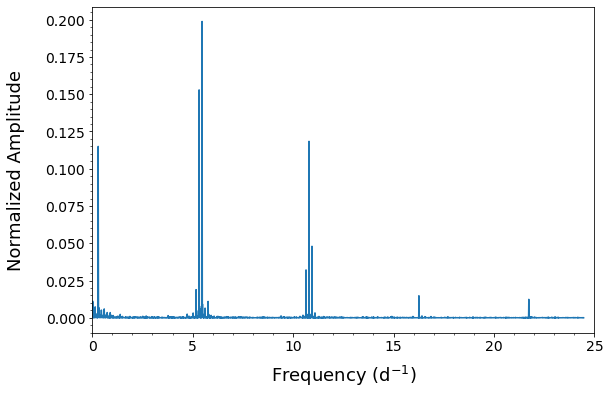

In [13]:
fcount = 2 # increment output file counter

# import specific packages needed here
from scipy import signal
from matplotlib.ticker import MultipleLocator

# calculate periodogram
# normalization = multiply periodogram amplitude by (2 / len(x))
start = time.time()
npgram = signal.lombscargle(x, y, w, normalize=True)

# visualize periodogram
fig, ax = plt.subplots()
ax.plot(f, npgram)

# plot decorations
y_minor_tick = 0.005
ax.axis([0,np.ceil(max(f)),-2*y_minor_tick,max(npgram)+2*y_minor_tick])
ax.minorticks_on()
ax.yaxis.set_minor_locator(MultipleLocator(y_minor_tick))
plt.xticks(fontsize=size_sm)
plt.yticks(fontsize=size_sm)
plt.xlabel('Frequency (d$^{-1}$)',fontsize=size_lg, labelpad=10)
plt.ylabel('Normalized Amplitude', fontsize=size_lg, labelpad=20)

# output visualization
plt.savefig(SAVEPATH+name_string+'_'+strfcount(fcount)+'_LSperiodogram.png',dpi=150, bbox_inches='tight')
stop = time_since(start)

# write logfile
logfile_out = open(logfile_name, 'a+')
print(timestamp(), file=logfile_out)
message1 = '*** Finished calculating L-S periodogram '+str(stop)
print(message1,'\n', file=logfile_out)
logfile_out.close()

# end this section gracefully
if LDEBUG >= 0: print(message1)


---
# Bootstrap the false alarm probability (FAP)

The FAP provides a means of evaluating the likelihood that a given peak in the periodogram is real (i.e., the inverse of the probability that the peak could have arisen by chance). The FAP is determined by performing a Monte Carlo simulation with many trials. In each trial, a new periodogram is calculated, with the input amplitude data randomly scrambled to different time values in each trial. The cumulative distribution of maximum peak heights in the trials results yields the FAP.

Because of the large number of trials, this step can be time consuming. The code has been written to allow for parallel processing on multiple cores. This step can also be skipped entirely, in which case a file of previouly generated peak heights is read in the next step.

In [ ]:
###############################################
# CUSTOMIZE ANY OF THESE AS NEEDED!!!

# select whether (True) or not (False) to run the Monte Carlo simulation, which is time-consuming
do_bootstrap = False
#do_bootstrap = True

# define parameters for FAP Monte Carlo simulation

# NOTE: even if do_bootstrap=False, the value of Np calculated below from the
# value of fap_desired is used to select the FAP data file to read in the next cell.

# 0.01 = 1% false positive rate
fap_desired = 0.0001  # = 0.01% Np = 100,000
#fap_desired = 0.0002  # = 0.02% Np =  50,000
#fap_desired = 0.0005  # = 0.05% Np =  20,000
#fap_desired = 0.001   # = 0.1%  Np =  10,000

# number of processor cores to use (should be <= actual number of available cores!)
# current maximum = 6 but can be extended by adding more "proc" statements below
nproc = 6
###############################################

fcount = 3 # increment output file counter

# calculate number of Monte Carlo trials based on desired precision of FAP probabilities
Np = int(10/fap_desired)

# write logfile
logfile_out = open(logfile_name, 'a+')
print(timestamp(), file=logfile_out)
print('### BOOTSTRAPPING THE FAP ###', file=logfile_out)
print('[user] run the Monte Carlo simulation? (do_bootstrap):',do_bootstrap, file=logfile_out)
print('[user] desired false positive rate (fap_desired):',fap_desired, file=logfile_out)
print('[user] number of processor cores used (nproc):',nproc, file=logfile_out)
print('number of Monte Carlo trials to reach fap_desired (Np):',Np, file=logfile_out)

if do_bootstrap == True:
    # import specific packages
    from random import SystemRandom
    from random import shuffle
    import copy
    from multiprocessing import Process, Queue

    # function for running on multiple processor cores
    def boostrap_func(x, y, w):
        # create shuffled version of amplitude data (y)
        y_trial = copy.copy(y)
        r.shuffle(y_trial)
        # calcualte trial periodogram using shuffled data
        npgram_trial = signal.lombscargle(x, y_trial, w, normalize=True)
        # save maximum peak height of trial periodogram as output of trial
        q.put(max(npgram_trial))

    # number of trials to perform with each processor core
    Np_multi = round(Np/nproc)
    
    if LDEBUG >= 2: print(fap_desired, Np, Np_multi, Np_multi*nproc)

    # implement OS-level randomization (better than python internal)
    r = SystemRandom()

    # run Monte Carlo simulation
    max_npgram_trial = []
    start = time.time()
    for j in range(Np_multi):
        # create a queue to share results
        q = Queue()
        # create nproc sub-processes to do the work
        if (nproc >= 1):
            proc1 = Process(target=boostrap_func, args=(x, y, w))
            proc1.start()
        if (nproc >= 2):
            proc2 = Process(target=boostrap_func, args=(x, y, w))
            proc2.start()
        if (nproc >= 3):
            proc3 = Process(target=boostrap_func, args=(x, y, w))
            proc3.start()
        if (nproc >= 4):
            proc4 = Process(target=boostrap_func, args=(x, y, w))
            proc4.start()
        if (nproc >= 5):
            proc5 = Process(target=boostrap_func, args=(x, y, w))
            proc5.start()
        if (nproc >= 6):
            proc6 = Process(target=boostrap_func, args=(x, y, w))
            proc6.start()
        
        results = []
        # grab values from the queue, one for each process
        for i in range(nproc):
            # set block=True to block until we get a result
            results.append(q.get(True))
    
        # join results from invidiual processors
        if (nproc >= 1):
            proc1.join()
        if (nproc >= 2):
            proc2.join()
        if (nproc >= 3):
            proc3.join()
        if (nproc >= 4):
            proc4.join()
        if (nproc >= 5):
            proc5.join()
        if (nproc >= 6):
            proc6.join()
    
        if LDEBUG >= 2: print(j, results)

        # create list of trial periodogram maximum peak heights for FAP statistics
        for k in range(nproc):
            max_npgram_trial.append(results[k])
        
        if LDEBUG >= 1: 
            if (j+1) <= 20 or (j+1) % 100 == 0:
                print(time_since(start), j+1, (j+1)*nproc, len(max_npgram_trial), max_npgram_trial[j], min(max_npgram_trial), max(max_npgram_trial))

    if LDEBUG >= 1: print(time_since(start), j+1, (j+1)*nproc, len(max_npgram_trial), max_npgram_trial[j], min(max_npgram_trial), max(max_npgram_trial))
    stop1 = time_since(start)
    message1 = '*** Finished bootstrapping iterations  '+str(stop1)
    if LDEBUG >= 0: print(message1)

    # write bootstrap results to output file
    fname1 = SAVEPATH+name_string+'_'+strfcount(fcount)+'_bootstrap_max_npgram_trials_'+str(Np)+'.txt'
    outfile = open(fname1, 'w')
    for row in max_npgram_trial:
        print(str(row), file=outfile)
    outfile.close()
    stop2 = time_since(start)
    message2 = '*** Finished writing file of bootstrap results  '+str(stop2)

    # write logfile
    print(message1, file=logfile_out)
    print(message2, file=logfile_out)
        
    # end this section gracefully
    if LDEBUG >= 0: print(message2)
else:
    message3 = '*** Skipping bootstrap simulation - read file of previous bootstrap results instead'
    # write logfile
    print(message3,'\n', file=logfile_out)
    
    if LDEBUG >= 0: print(message3)
        
logfile_out.close()


---
# Determine FAP confidence levels from bootstrap results

In [ ]:
###############################################
# CUSTOMIZE ANY OF THESE AS NEEDED!!!

# define histogram bins for peak heights
minbin = 0.002   # should be less than the actual minimum peak height in FAP M.C. simulation
maxbin = 0.015   # should be greater than the actual maximum peak height in FAP M.C. simulation
nhbins = 1000    # a reasonably large number, but avoid having bins with <10 counts

# desired FAP confidence levels to evaluate
fap_levels = ( [
0.9973,   # 3-sigma confidence
0.9545,   # 2-sigma confidence
0.90,     # 90% confidence
0.6827,   # 1-sigma confidence
0.50      # 50% confidence
])
###############################################

fcount = 4 # increment output file counter

# read FAP Monte Carlo results file
fname1 = SAVEPATH+name_string+'_'+strfcount(fcount-1)+'_bootstrap_max_npgram_trials_'+str(Np)+'.txt'
max_npgram_trial = np.loadtxt(fname1, usecols=(0))

if LDEBUG >= 1: print('Min/Max peak height in bootstrap simulation:', min(max_npgram_trial), max(max_npgram_trial))

# define histogram parameters
hdstep = (maxbin-minbin)/nhbins   # histogram bin width
hbins = [(minbin + hdstep*xx) for xx in range(nhbins+1)]   # histogram bin centers

if LDEBUG >= 1: print('Min/Max histogram bins for peak heights:', hbins[0], hbins[-1])

# evaluate the histogram
values, base = np.histogram(max_npgram_trial, bins=hbins)
# evaluate the cumulative probability function
cumulative = np.cumsum(values)
# plot the cumulative probability function
plt.plot(base[:-1], cumulative/max(cumulative), c='blue', zorder=3)
# plot the survival probability function
#plt.plot(base[:-1], 1.0-cumulative/max(cumulative), c='red')

# find peak heights at various confidence levels
fap_i = []
fap_x = []
for lval in fap_levels:
    idx = np.where(cumulative/max(cumulative) >= lval)
    fap_i.append(idx[0][0])
    fap_x.append(base[fap_i[-1]])

if LDEBUG >= 2: print(idx90, idx95, idx99)
if LDEBUG >= 1: 
    print('Np = ', Np)
    print('Peak height limits for FAP confidence levels of:')
    print([str(f"{ii*100:.2f}")+'% = '+str(f"{jj:.6f}") for ii, jj in zip(fap_levels, fap_x)])

# visualize the cumulative probability distribution
plt.axis([0.002, 0.009, -0.04, 1.04])

# plot decorations
plt.minorticks_on()
plt.xticks(fontsize=size_sm)
plt.yticks(fontsize=size_sm)
plt.xlabel('Normalized Periodogram Maximum Peak Height',fontsize=size_lg, labelpad=10)
plt.ylabel('Normalized Cumulative Counts', fontsize=size_lg, labelpad=20)
# y = 0, 1 lines (zorder controls order in which lines are drawn; lower = earlier)
plt.axhline(0, 0, 1, c='black', ls='--', lw=1, zorder=1)

# confidence level markers
for i, fl in enumerate(fap_levels):
    plt.plot([minbin, fap_x[i]], [fl, fl], c='black', ls='-', lw=1)
    plt.plot([fap_x[i], fap_x[i]], [-1, fl], c='black', ls='-', lw=1)

# output the visualization
plt.savefig(SAVEPATH+name_string+'_'+strfcount(fcount)+'_fap_cumulative_trials_'+str(Np)+'.png',dpi=150, bbox_inches='tight')

# write logfile
logfile_out = open(logfile_name, 'a+')
print(timestamp(), file=logfile_out)
print('### FAP CONFIDENCE LEVELS ###', file=logfile_out)
print('FAP bootstrap simulation results file:',fname1, file=logfile_out)
print('minimum, maximum peak height in bootstrap simulation:',min(max_npgram_trial),max(max_npgram_trial), file=logfile_out)
print('[user] minimum, maximum peak height bins in histogram (minbin, maxbin) =',minbin,maxbin, file=logfile_out)
print('number of points in FAP simulation (Np):',Np, file=logfile_out)
print('[user] number of histogram bins (nhbins) =',nhbins, file=logfile_out)
print('[user] desired FAP confidence levels to evaluate (fap_levels) =',fap_levels, file=logfile_out)
print('    Fiducial FAP confidence levels:', file=logfile_out)
print('        0.9973 = 3-sigma', file=logfile_out)
print('        0.9545 = 2-sigma', file=logfile_out)
print('        0.90   = 90%', file=logfile_out)
print('        0.6827 = 1-sigma', file=logfile_out)
print('        0.50   = 50%', file=logfile_out)
print('Peak height limits for FAP confidence levels of:', file=logfile_out)
print([str(f"{ii*100:.2f}")+'% = '+str(f"{jj:.6f}") for ii, jj in zip(fap_levels, fap_x)], file=logfile_out)
message1 = '*** Finished determining FAP levels from bootstrap simulation results'
print(message1,'\n', file=logfile_out)
logfile_out.close()

# end this section gracefully
if LDEBUG >= 0: print('\n', message1)


---
# Identify and characterize the peaks in the periodogram
Use Gaussian fitting to find centers (frequencies) and hwhm (uncertainties) of the periodogram peaks above a threshhold value. Assign a FAP confidence level based on the height of each peak.

In [ ]:
###############################################
# CUSTOMIZE ANY OF THESE AS NEEDED!!!

# set height threshold for finding peaks
# [-1 = find all peaks down to lowest defined FAP confidence level]
phlim = fap_x[-1]

# change plot dimensions
plt.rcParams["figure.figsize"] = (20,10)

# show individual Gaussian fitting peak plots
show_plots = False
#show_plots = True
###############################################

# import specific packages needed here
from scipy.optimize import curve_fit
from scipy.signal import find_peaks

# define Gaussian fitting function
def gaussfunc(gx,ga,gx0,gsigma):
    return ga*np.exp(-(gx-gx0)**2/(2*gsigma**2))

# visualize the unfolded light curve data (diagnostic only - not intended for publication)
plt.subplots_adjust(hspace=0.35)
plt.subplot(3, 1, 1)
plt.plot(x-x[0], y, 'b+')
plt.xlabel('Time (d)', size=size_sm)
plt.ylabel('Amplitude', size=size_sm)
plt.minorticks_on()

# visualize the periodogram (diagnostic only - not intended for publication)
plt.subplots_adjust(hspace=0.35)
plt.subplot(3, 1, 2)
plt.plot(f, npgram)
plt.xlabel('Frequency (d$^{-1}$)', size=size_sm)
plt.ylabel('Normalized Amplitude', size=size_sm)
plt.axis([fmin, fmax, 0, 1.1*max(npgram)])

# find peaks in the periodogram using height threshhold from FAP plot (above)
peaks, _ = find_peaks(npgram, height=phlim)

if LDEBUG >= 2: 
    for i, ipeak in enumerate(peaks):
        print(ipeak, '  ', f[ipeak], '  ', 1.0/f[ipeak], '  ', npgram[ipeak])

# define DataFrame for holding periodogram peaks info
peaks_colnames = ['height', 'frequency', 'sigma', 'HWHM', 'period', 'unc', 'FAPconf', 'j', 'kmin', 'kmax', 'npts']
df_pd_peaks = pd.DataFrame(columns=peaks_colnames)

# Start the peak-fitting process
# Loop through the identified peaks
peak_fit_center = []
for i in range(len(peaks)):
    j = peaks[i]
    
    # assign FAP score
    for ii in range(len(fap_x)):
        if LDEBUG >= 2: print(ii, j, npgram[j], fap_x[ii], fap_levels[ii])
        if npgram[j] >= fap_x[ii]:
            fap_out = '>'+str(f"{fap_levels[ii]*100:.2f}")+'%'
            break

    # Find range around peak for the Gaussian fit (start at peak and count points 
    # in both directions until the "next" point is higher than the current one)
    # find range shortward of peak
    kmin = j
    while npgram[kmin-1] < npgram[kmin]:
        kmin = kmin-1
    # find range longward of peak
    kmax = j
    while npgram[kmax+1] < npgram[kmax]:
        kmax = kmax+1
    kmax += 1
    
    # define sub-arrays for Gaussian fitting
    gx = f[kmin:kmax]
    gy = npgram[kmin:kmax]
    gn = len(gx)                          
    gmean = sum(gx*gy)/sum(gy)               
    gsigma = np.sqrt(sum(gy * (gx - gmean)**2) / sum(gy))
    
    # perform Gaussian fitting and recover fit parameters
    popt,pcov = curve_fit(gaussfunc,gx,gy,p0=[npgram[j],gmean,gsigma])
    if LDEBUG >= 2: 
        print([npgram[j],gmean,gsigma])
        print(popt)
    rampl = round(popt[0],8)
    rcent = round(popt[1],8)
    rsigm = round(popt[2],8)
    rhwhm = round(rsigm*np.sqrt(2.0*np.log(2.0)),8)
    
    rperd = round(1.0/popt[1],8)
    rpunc = round(((rsigm*np.sqrt(2.0*np.log(2.0)))/popt[1] * (1.0/popt[1])), 8)
    
    peak_fit_center.append(rcent)
    
    # optionally show zoomed plots of individual peaks with overlaid Gaussian fitting results
    if show_plots == True:
        plt.subplot(3, 1, 3)
        plt.plot(f, npgram)
        plt.xlabel('Frequency (d$^{-1}$)', size=size_sm)
        plt.ylabel('Normalized Amplitude', size=size_sm)
        plt.axis([f[kmin-10], f[kmax+10], 0, 1.1*max(npgram[kmin:kmax])])
        if LDEBUG >= 2: 
            print(f[kmin-10], f[kmax+10], 0, 1.1*max(npgram[kmin:kmax]))
            for ii in peaks:
                plt.plot(f[ii], npgram[ii], "rx")
        plt.plot(gx,gaussfunc(gx,*popt),'ro:',label='fit')
        plt.pause(0.01)
   
    # append fit parameters to DataFrame
    df_params = [rampl, rcent, rsigm, rhwhm, rperd, rpunc, fap_out, int(j), int(kmin), int(kmax), int(kmax-kmin)]
    df_pd_peaks = df_pd_peaks.append(pd.Series(df_params, index=df_pd_peaks.columns), ignore_index=True)

# print table of peak fit parameters
pd.options.display.float_format = '{:.8f}'.format
print(df_pd_peaks.iloc[:, [0,1,3,4,5,6]])

# restore default plot size
plt.rcParams["figure.figsize"] = PSIZE_DEFAULT

# write logfile
logfile_out = open(logfile_name, 'a+')
print(timestamp(), file=logfile_out)
print('### PERIODOGRAM PEAKS ###', file=logfile_out)
print('[user] height threshold for finding peaks (phlim):',phlim, file=logfile_out)
print(df_pd_peaks.iloc[:, [0,1,3,4,5,6]], file=logfile_out)
message1 = '*** Finished identification and gaussian fits of periodogram peaks'
print(message1,'\n', file=logfile_out)
logfile_out.close()

# end this section gracefully
if LDEBUG >= 2: print(df_pd_peaks)
if LDEBUG >= 0: print('\n', message1)


---
# Find frequency relationships

In [ ]:
###############################################
# CUSTOMIZE ANY OF THESE AS NEEDED!!!

# Define spin frequency peak index
i = 11

# Define orbital frequency peak index
j = 8

# sigma-difference limit for identifying a potential frequency relationship
siglim = 1.0
###############################################

# Output selected spin & orbital periods
s = df_pd_peaks.frequency[i]
es = df_pd_peaks.HWHM[i]
spacer = ''
if i < 10: spacer = ' '
print('   Spin frequency['+str(i)+'] '+spacer+'[s] =', s, '+/-', es)

o = df_pd_peaks.frequency[j]
eo = df_pd_peaks.HWHM[j]
spacer = ''
if j < 10: spacer = ' '
print('Orbital frequency['+str(j)+'] '+spacer+'[o] =', o, '+/-', eo)

# find frequency with smallest difference from given value
def find_min_diff(frq):
    diff = abs(frq - df_pd_peaks.frequency)
    return np.argmin(np.array(diff))

# print results
def freq_compare(lbl,frq,err,frq_obs,err_obs,logfile_out):
    diff = frq_obs - frq   # difference
    ediff = np.sqrt(err_obs**2 + err**2)   # difference uncertainty
    sigma_diff = diff/ediff   # difference as multiple of uncertainty ("sigma difference")
    spacer2 = ' '
    if imin < 10: spacer2 += ' '
    messageX0 = '\n%12s =  %.8f +/- %.8f' %(lbl, frq, err)
    print(messageX0)
    print(messageX0, file=logfile_out)
    if abs(sigma_diff) <= siglim:
        pdiff = 100.0*diff/frq   # percentage difference (relative to frq)
        epdiff = abs((100.0*diff/frq)*np.sqrt((ediff/diff)**2 + (err/frq)**2))   # percentage error of percentage difference
        spacer = ' '
        if diff < 0: spacer = ''
        messageX1 = spacer2+'frq_obs[%i] =  %.8f +/- %.8f' %(imin, frq_obs, err_obs)
        messageX2 = '        diff =%s %.8f +/- %.8f (%.2f sigma; %.2f%% +/- %.2f%%)' %(spacer, diff, ediff, sigma_diff, pdiff, epdiff) 
        print(messageX1)
        print(messageX2)
        print(messageX1, file=logfile_out)
        print(messageX2, file=logfile_out)
    else:
        messageX3 = '***WARNING: No potential frequency relationship found within |sigma_diff| <= '+str(siglim)
        print(messageX3)
        print(messageX3, file=logfile_out)
    return sigma_diff

# define possible frequency relationships
lbl = []
frq = []
err = []

lbl.append('2o')
frq.append(2*o)
err.append(2*eo)

lbl.append('2s')
frq.append(2*s)
err.append(2*es)

lbl.append('s-o')
frq.append(s-o)
err.append(np.sqrt(eo**2 + es**2))

lbl.append('2(s-o)')
frq.append(2*(s-o))
err.append(np.sqrt(eo**2 + es**2) * 2)

lbl.append('3(s-o)')
frq.append(3*(s-o))
err.append(np.sqrt(eo**2 + es**2) * 3)

lbl.append('4(s-o)')
frq.append(4*(s-o))
err.append(np.sqrt(eo**2 + es**2) * 4)

lbl.append('2s - o')
frq.append(2*s-o)
err.append(np.sqrt((2.0*es)**2 + eo**2))

lbl.append('3s - 2o')
frq.append(3*s-2*o)
err.append(np.sqrt((3.0*es)**2 + (2.0*eo)**2))

lbl.append('4s - 3o')
frq.append(4*s-3*o)
err.append(np.sqrt((4.0*es)**2 + (3.0*eo)**2))

lbl.append('s+o')
frq.append(s+o)
err.append(np.sqrt(eo**2 + es**2))

lbl.append('2s + o')
frq.append(2*s+o)
err.append(np.sqrt((2.0*es)**2 + eo**2))

lbl.append('3s + o')
frq.append(3*s+o)
err.append(np.sqrt((3.0*es)**2 + eo**2))

lbl.append('2o - s')
frq.append(2*o-s)
err.append(np.sqrt((2.0*eo)**2 + es**2))

lbl.append('3o - 2s')
frq.append(3*o-2*s)
err.append(np.sqrt((3.0*eo)**2 + (2.0*es)**2))

lbl.append('4o - 3s')
frq.append(4*o-3*s)
err.append(np.sqrt((4.0*eo)**2 + (3.0*es)**2))

lbl.append('o - (s-o)/8')
frq.append(o-(s-o)/8)
err.append(np.sqrt(eo**2 + (es/8.0)**2 + (eo/8.0)**2))

lbl.append('o + (s-o)/8')
frq.append(o+(s-o)/8)
err.append(np.sqrt(eo**2 + (es/8.0)**2 + (eo/8.0)**2))

lbl.append('s - (s-o)/5')
frq.append(s-(s-o)/5)
err.append(np.sqrt(es**2 + (es/5.0)**2 + (eo/5.0)**2))

lbl.append('s - (s-o)/8')
frq.append(s-(s-o)/8)
err.append(np.sqrt(es**2 + (es/8.0)**2 + (eo/8.0)**2))

lbl.append('s + (s-o)/8')
frq.append(s+(s-o)/8)
err.append(np.sqrt(es**2 + (es/8.0)**2 + (eo/8.0)**2))

lbl.append('o/16')
frq.append(o/16)
err.append(eo/16)

# write logfile
logfile_out = open(logfile_name, 'a+')
print(timestamp(), file=logfile_out)
print('### FREQUENCY RELATIONSHIPS ###', file=logfile_out)
print('[user] spin frequency index [i]:', i, file=logfile_out)
print('[user] orbital frequency index [j]:', j, file=logfile_out)
print('[user] sigma-difference limit for identifying a potential frequency relationship [siglim]:',siglim, file=logfile_out)
print('spin frequency['+str(i)+'] '+spacer+'[s] =', s, '+/-', es, file=logfile_out)
print('orbital frequency['+str(j)+'] '+spacer+'[o] =', o, '+/-', eo, file=logfile_out)

# do the math!
imin_used = [i,j]   # keep track of used frequncies
for k in range(len(lbl)):
    imin = find_min_diff(frq[k])
    sigma_diff = freq_compare(lbl[k],frq[k],err[k],df_pd_peaks.frequency[imin],df_pd_peaks.HWHM[imin],logfile_out)
    if LDEBUG >= 2: print(k, sigma_diff)
    if abs(sigma_diff) <= siglim:
        if imin in imin_used:
            message1 = '***WARNING: Frequency already used, frq_obs['+str(imin)+'] = '+str(df_pd_peaks.frequency[imin])
            print(message1)
            print(message1, file=logfile_out)
        else: imin_used.append(imin)
    
# note any unused frequencies
imin_possible = range(len(df_pd_peaks.frequency))
start, end = imin_possible[0], imin_possible[-1]
imin_unused = sorted(set(range(start, end + 1)).difference(imin_used))
if LDEBUG >= 2: print('\n', start, end, imin_possible, imin_used, imin_unused)
if len(imin_unused) > 0:
    message2 = '\nUnused frequencies:'
    print(message2)
    print(message2, file=logfile_out)
    for k in imin_unused:
        spacer3 = ''
        if k < 10: spacer3 = ' '
        message3 = ' frq_obs['+str(k)+'] '+spacer3+'= '+str(df_pd_peaks.frequency[k])+'  (period = '+str(round(1.0/df_pd_peaks.frequency[k],8))+')'
        print(message3)
        print(message3, file=logfile_out)
else: 
    message4 = '\nNo unused frequencies!'
    print(message4)
    print(message4, file=logfile_out)

# finish logfile entry
message5 = '*** Finished identifying potential frequency relationships (for |sigma_diff| <= '+str(siglim)+')'
print(message5,'\n', file=logfile_out)
logfile_out.close()

# end this section gracefully
if LDEBUG >= 0: print('\n', message5)


---
# Visualize periodogram with expanded scale and identified peaks

In [ ]:
###############################################
# CUSTOMIZE ANY OF THESE AS NEEDED!!!

# mark peaks down to specified element of fap_levels with longer (blue) marker
# (all other peaks will be marked with shorter (red) marker)
faplim = 2  ### this is the 90% confidence level

# number of panels to show
npanels = 3

# update this dictionary to include settings for each panel
#    xmin, xmax = minimum, maximum frequency to plot
#    ymin, ymax = minimum, maximum power to plot
#    y_minor_tick = size of y-axis minor tick intervals
if tidx == 0:
    panparms = ( {
    'xmin':[0.0,  5.1, 10.4],
    'xmax':[0.8,  5.9, 11.2],
    'ymin':[0.0,  0.0,  0.0],
    'ymax':[0.20, 0.20, 0.20],
    'y_minor_tick':[0.010, 0.010, 0.010]
    } )
if tidx == 1:
    panparms = ( {
    'xmin':[0.0,  5.1, 10.4],
    'xmax':[0.8,  5.9, 11.2],
    'ymin':[0.0,  0.0,  0.0],
    'ymax':[0.005, 0.005, 0.005],
    'y_minor_tick':[0.001, 0.001, 0.001]
    } )
###############################################

fcount = 5 # increment output file counter

# handle obvious error(s)
if tidx > len(tname)-1:
    if LDEBUG >= 0: print('ERROR: No plot window settings defined')

# set up the multipanel plot
fig, axes = plt.subplots(npanels, 1, figsize=(10,npanels*3))

# centered common axis labels
fig.text(0.5, 0.04, 'Frequency (d$^{-1}$)', ha='center', size=size_lg)
fig.text(0.02, 0.5, 'Normalized Amplitude', va='center', rotation='vertical', size=size_lg)

# set font size for axis tick labels
plt.rc('xtick', labelsize=size_sm) 
plt.rc('ytick', labelsize=size_sm) 

# loop over panels
for i, ax in enumerate(axes.flatten()):
    # plot data into current panel
    if LDEBUG >= 2: print(i, ax)
    ax.plot(f, npgram, color='black', linewidth=1)

    # plot decorations
    pstep = panparms['y_minor_tick'][i]
    ax.axis([panparms['xmin'][i], panparms['xmax'][i], panparms['ymin'][i]-2*panparms['y_minor_tick'][i], panparms['ymax'][i]+2*panparms['y_minor_tick'][i]], fontsize=size_sm)
    ax.minorticks_on()
    ax.yaxis.set_minor_locator(MultipleLocator(panparms['y_minor_tick'][i]))
    
    # plot markers for the gaussian fit peak centers from the previous cell
    for ii in range(len(peak_fit_center)):
        j = peaks[ii]
        if LDEBUG >= 2: print(j, peaks[ii], npgram[j])
        if npgram[j] >= fap_x[faplim]:
            ax.plot([peak_fit_center[ii],peak_fit_center[ii]], [npgram[j]-pstep,npgram[j]+2*pstep], color='blue')
        else:
            ax.plot([peak_fit_center[ii],peak_fit_center[ii]], [npgram[j]-pstep,npgram[j]+pstep], color='red')

# output the visualization
plt.savefig(SAVEPATH+name_string+'_'+strfcount(fcount)+'_LSperiodogram_panels.png',dpi=150, bbox_inches='tight')

# write logfile
logfile_out = open(logfile_name, 'a+')
print(timestamp(), file=logfile_out)
print('### PERIODOGRAM PEAKS VISUALIZATION ###', file=logfile_out)
message1 = '*** Finished plotting periodogram peaks (marker split at FAP level', '>'+str(f"{fap_levels[faplim]*100:.2f}")+'%)'
print(message1,'\n', file=logfile_out)
logfile_out.close()

if LDEBUG >=2:
    print(fap_x)
    print(fap_levels)

# end this section gracefully
if LDEBUG >= 0: print(message1)


---
# Calculate the phases for all periods
Converts data time values into phases corresponding to all of the periodogram peaks identified above

In [ ]:
###############################################
# CUSTOMIZE ANY OF THESE AS NEEDED!!!

# OPTIONAL phase offset to add to calculated phases
phi_offset = 0.0

# OPTIONAL time zeropoint for calculating phases (-1 to use first time)
phi_zeropoint = -1
###############################################

if phi_zeropoint < 0: phi_zeropoint = df_lc_clean.time.to_numpy(copy=True)[0]

if LDEBUG >= 2: 
    print('phi_zeropoint =', phi_zeropoint)
    print(df_lc_clean.time.to_numpy(copy=True))

# loop over periods
for i in range(len(df_pd_peaks.period)):
    colname = str(i)
    #if i < 100: colname = '0'+colname
    if i < 10: colname = '0'+colname
    colname = 'phi'+colname
    
    if LDEBUG >= 2: 
        print(colname)
        print(df_pd_peaks.period.to_numpy(copy=True)[i])
    
    # add new column for each set of phases to existing DataFrame
    df_lc_clean[colname] = (df_lc_clean.time.to_numpy(copy=True) - phi_zeropoint)/df_pd_peaks.period.to_numpy(copy=True)[i] + phi_offset

# write logfile
logfile_out = open(logfile_name, 'a+')
print(timestamp(), file=logfile_out)
print('### PHASE CALCULATIONS ###', file=logfile_out)
print('[user] offset added to calculated phases (phi_offset):',phi_offset, file=logfile_out)
print('[user] time zeropoint for calculating phases [-1 to use first time] (phi_zeropoint):',phi_zeropoint, file=logfile_out)
message1 = '*** Finished calculating phases'
print(message1,'\n', file=logfile_out)
logfile_out.close()

# end this section gracefully
if LDEBUG >= 2: print(df_lc_clean)

if LDEBUG >= 0: print(message1)


---
# Phase binning
Average the phases for a user-selected period into a user-defined number of bins per cycle. The result is a binned light curve for each cycle of the period, and a final "average" light curve for the entire phase-folded data set for the period.

In [ ]:
###############################################
# CUSTOMIZE ANY OF THESE AS NEEDED!!!

# step size for phase bins (1/dstep should be an integer)
#dstep = 0.10
dstep = 0.05
###############################################

# half of a phase bin width
dshift = dstep/2.0
# number of phase bins
nphibins = int(1.0/dstep)

if LDEBUG >= 1: print('nphibins = ',nphibins)

# calculate phase bin starting points
pbins = [(0.0 + dstep*x)-(dstep/2.0) for x in range(nphibins+1)]
pbins[0] = pbins[0]+1.0
pbins = [round(i,3) for i in pbins]

if LDEBUG >= 2: print(pbins)

# calculate centers of phase bins
pcbins = [(0.0 + dstep*x) for x in range(nphibins)]
pcbins.append(pcbins[0]+1.0)
pcbins = [round(i,3) for i in pcbins]

if LDEBUG >= 1: print('Bin centers:', pcbins)

# write logfile
logfile_out = open(logfile_name, 'a+')
print(timestamp(), file=logfile_out)
print('### PHASE BINNING ###', file=logfile_out)
print('[user] step size for phase bins [1/dstep should be an integer] (dstep):',dstep, file=logfile_out)
print('half of a phase bin width (dshift):',dshift, file=logfile_out)
print('number of phase bins (nphibins):',nphibins, file=logfile_out)
print('phase bins (pbins):',pbins, file=logfile_out)
print('phase bin centers (pcbins):',pcbins, file=logfile_out)

# define new dictionary to hold DataFrames for phase-binned data for all periods
df_lc_clean_bin = {}

start = time.time()
for pidx in range(len(df_pd_peaks.period)):
    # sort data into phase bins
    spidx = str(pidx)
    if pidx < 10: spidx = '0'+spidx
    p = np.copy(df_lc_clean['phi'+spidx])
    a = np.copy(df_lc_clean['varflux'])
    
    message1 = 'Processing phased period data '+spidx+' (period = '+str(df_pd_peaks.period[pidx])+')  '+str(time_since(start))
    if LDEBUG >= 0: 
        print(message1)
    print(message1, file=logfile_out)
    
    # define new DataFrame to store phase-binned data for one period
    phi_colnames1 = [str(i) for i in pcbins]
    phi_colnames2 = [str(i+1) for i in pcbins]
    phi_colnames = phi_colnames1 + phi_colnames2[1:]
    df_lc_clean_bin_one = pd.DataFrame(columns=phi_colnames)

    if LDEBUG >= 2: print(df_lc_clean_bin_one)

    # running sum for each phase bin for all cycles (default is 0.0)
    allbinsum = [0.0 for i in range(nphibins)]
    # running total of data points summed into each phase bin for all cycles (deault is 0)
    allbinnum = [0 for i in range(nphibins)]
    # average in each phase bin for all cycles (default is Nan)
    allbinavg = [np.nan for i in range(nphibins)]
    # standard deviation of average in each phase bin for all cycles (default is Nan)
    allbinerr = [np.nan for i in range(nphibins)]
    
    # loop over all phase cycles in input data
    for i in range(int(np.floor(max(p)))):
        # running sum for each phase bin for one cycle (default is 0.0)
        binsum = [0.0 for i in range(nphibins)]
        # running total of data points summed into each phase bin for one cycle (default is 0)
        binnum = [0 for i in range(nphibins)]
        # average in each phase bin for one cycle (default is Nan)
        binavg = [np.nan for i in range(nphibins)]
    
        # create subarrays containing only data in the current cycle
        subp = p[(p >= i) & (p < i+1)]
        suba = a[(p >= i) & (p < i+1)]    
    
        if len(subp) > 0:    
            # truncate phases to keep just decimal part
            subpdec = np.array([mphi(ii) for ii in subp])
        
            # loop over all phase bins
            for j, pcbin in enumerate(pcbins[0:-1]):
                # create mask file for reducing length of subarray after data points have been used
                mask = np.ones(len(subp), dtype=bool)
                mask_flag = False

                # sort appropriate data into current phase bin
                for k, suba1 in enumerate(suba):                        
                    if (mphi(subpdec[k]+dshift) >= pcbin and mphi(subpdec[k]+dshift) < pcbin+dstep):
                        allbinsum[j] += suba1
                        allbinnum[j] += 1
                        binsum[j] += suba1
                        binnum[j] += 1
                        
                        # flag used data points in mask file
                        mask[k] = False
                        mask_flag = True
                
                # reduce length of subarrays if any data points were masked
                if mask_flag == True:
                    subp = subp[mask]
                    suba = suba[mask]
                    subpdec = subpdec[mask]
                
                # calculate average value in current bin
                if binnum[j] > 0: binavg[j] = binsum[j]/binnum[j]
                
            # append copy of phase bin averages to provide two cycles of phased data
            for ii in range(nphibins):
                binavg.append(binavg[ii])
            binavg.append(binavg[0])

            if LDEBUG >= 2: print(binsum, binnum, binavg)
        
            # store average phase bin values for this cycle in a row of the dataframe
            df_lc_clean_bin_one = df_lc_clean_bin_one.append(pd.Series(binavg, index=df_lc_clean_bin_one.columns), ignore_index=True)
        else:
            message2 = '***WARNING: no data for phase cycle'+str(i)
            if LDEBUG >= 0: 
                print(message2)
            print(message2, file=logfile_out)

        if LDEBUG >= 2:
            print('\n===========================================================\n')

    # calculate average and standard deviation values in phase bins for all cycles
    for j in range(nphibins):
        if allbinnum[j] > 0:
            allbinavg[j] = allbinsum[j]/allbinnum[j]
        allbinerr[j] = np.std(df_lc_clean_bin_one[phi_colnames[j]])
    
    # append copy of phase bin averages and standard deviations to provide two cycles of phased data
    for ii in range(nphibins):
        allbinavg.append(allbinavg[ii])
        allbinerr.append(allbinerr[ii])
    allbinavg.append(allbinavg[0])        
    allbinerr.append(allbinerr[0])        

    # store average phase bin values for all cycles in next-to-last row of the DataFrame
    # This is the "average" light curve for each period
    df_lc_clean_bin_one = df_lc_clean_bin_one.append(pd.Series(allbinavg, index=df_lc_clean_bin_one.columns), ignore_index=True)
    # store average phase bin standard deviations for all cycles in last row of the DataFrame
    df_lc_clean_bin_one = df_lc_clean_bin_one.append(pd.Series(allbinerr, index=df_lc_clean_bin_one.columns), ignore_index=True)

    # add the average light curve to the DataFrame for this period phasing
    df_lc_clean_bin['phi'+spidx] = df_lc_clean_bin_one

# finish logfile entry
message3 = '*** Finished phase binning  '+str(time_since(start))
print(message3,'\n', file=logfile_out)
logfile_out.close()

# end this section gracefully
if LDEBUG >= 2:
    print('\n')
    print(df_lc_clean_bin_one)

if LDEBUG >= 0: print('\n',message3)


---
# One-dimensional light curve(s)
Visualize the data as a 1-d light curve (X = phase, Y = amplitude)

In [ ]:
###############################################
# CUSTOMIZE ANY OF THESE AS NEEDED!!!

# select period(s) from list of periods defined above (df_pd_peaks.periods)
pidx = [11, 8, 1] # orbit, spin, beat
#pidx = [11, 8, 1, 0, 2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19] # orbit, spin, beat, and the rest...

# plot axis ranges [xmin, xmax, ymin, ymax]
if tidx == 0:
    paxvals = [0,2,-50,120]
if tidx == 1:
    paxvals = [0,2,-15,15]
###############################################

fcount = 6 # increment output file counter

# determine number of light curves to be plotted
npanels = len(pidx)

# calculate "half" of number of panels for use in multicolumn plotting
n2 = int(np.ceil(npanels/2))

# set up the multipanel plot
if npanels <= 4:
    # single column of plots
    fig, axes = plt.subplots(npanels, 1, sharex=False, figsize=(10,npanels*5), gridspec_kw={'hspace': 0.225})
    plxpos = [0.51, 0.09-0.01*(4-npanels)**2]
    plypos = [0.02, 0.50]
else:
    # double column of plots
    fig, axes = plt.subplots(n2, 2, sharex=False, sharey=True, figsize=(20,5*n2), gridspec_kw={'hspace': 0.225, 'wspace': 0.06})
    if n2 > 3:
        plxpos = [0.5125, 0.09+0.0038*(n2-4)]
    else:
        plxpos = [0.5125, 0.075]
    plypos = [0.08, 0.50]
    
# centered common axis labels
fig.text(plxpos[0], plxpos[1], 'Phase', ha='center', size=size_lg)
fig.text(plypos[0], plypos[1], 'Flux Amplitude (%)', va='center', rotation='vertical', size=size_lg)

# loop over panels
for i in range(npanels):    
    # convert selected phasing into string for selecting correct DataFrame from dictionary
    spidx = str(pidx[i])
    if pidx[i] < 10: spidx = '0'+spidx
    spidx = 'phi'+spidx

    # select unbinned light curve data
    x = [mphi(phi) for phi in df_lc_clean[spidx].to_numpy(copy=True)]
    y = [amp for amp in df_lc_clean['varflux'].to_numpy(copy=True)]

    # double x, y, for plotting 2 cycles
    for j in range(len(x)):
        x.append(x[j]+1.0)
        y.append(y[j])
    
    # move to current subplot panel
    if npanels == 1:
        ax = axes
    else:
        if npanels <= 4:
            ax = axes[i]
        else:
            axflat = axes.flatten()
            # hide unused subplot panel if there is an odd number of panels in multicolumn format
            if i+1 == npanels and npanels % 2 > 0:
                ax = axflat[i+1]
                ax.set_visible(False)
            ax = axflat[i]
    
    # plot unbinned light curve
    ax.plot(x, norm_self(y), color='k', marker='.', markersize='1', linewidth=0)

    # convert column names (phase bin centers) to numbers for plotting
    xavg = []
    for column in df_lc_clean_bin[spidx].columns:
        xavg.append(float(column))

    # copy average light curve data and create normalized versions   
    yavg = np.copy(df_lc_clean_bin[spidx].iloc[-2])    
    yavg_norm = norm_other(yavg,varflux_mean)
    yavgerr = np.copy(df_lc_clean_bin[spidx].iloc[-1])
    yavgerr_norm = (yavgerr/yavg)*yavg_norm
    
    # plot averaged light curve stored in last row of DataFrame
    ax.errorbar(xavg, yavg_norm, yavgerr_norm, barsabove=False, color='r', marker='o', markersize='8', linewidth=0, elinewidth=1)

    # plot decorations
    ax.tick_params(labelsize=size_sm)
    ax.axis(paxvals)
    ax.minorticks_on()
    ax.xaxis.set_minor_locator(MultipleLocator(0.05))
    #ax.yaxis.set_minor_locator(MultipleLocator(10))
    ax.set_title('Period = '+str(df_pd_peaks.period[pidx[i]]), fontsize=size_sm, pad=8)

plt.savefig(SAVEPATH+name_string+'_'+strfcount(fcount)+'_lc_folded_'+str(npanels)+'.png',dpi=150, bbox_inches='tight')

# write logfile
logfile_out = open(logfile_name, 'a+')
print(timestamp(), file=logfile_out)
print('### ONE-DIMENSIONAL LIGHT CURVE(S) VISUALIZATION ###', file=logfile_out)
message1 = '*** Finished plotting folded light curve(s)'
print(message1,'\n', file=logfile_out)
logfile_out.close()

if LDEBUG >= 0: print(message1)


---
# Two-dimensional light curve
Visualize the data as a 2-d light curve (X = phase, Y = cycles)

In [ ]:
###############################################
# CUSTOMIZE ANY OF THESE AS NEEDED!!!

# select period from list of periods defined above (df_pd_peaks.periods)
pidx =  8 # orbit
#pidx = 11 # spin

# Select size(s) of the moving window for smoothing (number of cycles, [min, max])
# Set min to be the smallest number that eliminates all Nans (white pixels) in the visualization
wroll = [ 7, 14]
#wroll = [12, 24]

# color map name
pcmap = 'viridis'
#pcmap = 'plasma'
#pcmap = 'magma'
#pcmap = 'inferno'
#pcmap = 'cividis'

# skip outputting plot?
DO_SKIP=False
#DO_SKIP=True
###############################################

fcount = 7 # increment output file counter

# convert selected phasing into string for selecting correct DataFrame from dictionary
spidx = str(pidx)
if pidx < 10: spidx = '0'+spidx
spidx = 'phi'+spidx

# select correct DataFrame from dictionary (ignoring last 2 rows, which contain averages and uncertinaties)
df_lc_clean_bin_one = df_lc_clean_bin[spidx].iloc[0:-2]
        
# define the number of rows in the visualization image
numrows = len(df_lc_clean_bin_one.index)

# aspect ratio (1.0 = 1:1)
pasp = 3.0*2.0/numrows

# offsets from axis for axis labels (in data units)
plxpos = -0.00005*numrows
plypos = -0.05

# set up the multipanel visualization
gs_kw=dict(wspace=0.02)
fig, axN = plt.subplots(1,3, sharey=True, figsize=(8.4,7), constrained_layout=True, gridspec_kw=gs_kw)

# common axis labels shared by subplot panels
#fig.text(plxpos[0], plxpos[1], 'Phase (period = '+str(df_pd_peaks.period[pidx])+' d)', ha='center', size=size_lg)
fig.text(0.5, plxpos, 'Phase (period = '+str(df_pd_peaks.period[pidx])+' d)', ha='center', size=size_lg)
fig.text(plypos, 0.5, 'Cycles (N='+str(numrows)+')', va='center', rotation='vertical', size=size_lg)

# Visualize the data as a 2-dimensional light curve
# Three panels show: (1) raw data, (2 & 3) data smoothed by a moving window average (window widths defined above)
imethod = 'none'
for i in range(0,3):
    # make new DataFrame for working in
    df_lc_clean_binavg = df_lc_clean_bin_one.copy()
    # convert amplitudes to percentage variability
    for colname in phi_colnames:
        df_lc_clean_binavg[colname] = norm_other(df_lc_clean_bin_one[colname], varflux_mean)
    
    # apply moving window smoothing
    if i >= 1:
        for colname in phi_colnames:
            df_lc_clean_binavg[colname] = df_lc_clean_binavg[colname].rolling(window=wroll[i-1], min_periods=1, center=True).mean()

    # label subplots
    if i == 0:
        ltitle = 'Raw'   # Missing data (Nans) are visualized in white
    else:
        ltitle = 'N$_{\mathrm{roll}}$='+str(wroll[i-1])

    # visualize data into subplots
    im = axN[i].imshow(df_lc_clean_binavg,aspect=pasp,origin='lower',extent=[0.0,2.0,0,numrows],interpolation=imethod,cmap=pcmap)
    
    # format and label tickmarks
    axN[i].tick_params(labelsize=size_sm, length=5)
    axN[i].set_xticks((0, 0.5, 1, 1.5, 2))
    axN[i].set_xticklabels(('0','0.5','1','1.5','2'))
    axN[i].set_title('('+abclabels[i]+') '+ltitle, fontsize=size_sm, pad=10)

    # display color bar
    if i == 2:
        cbar = fig.colorbar(im, ax=axN[i], shrink=0.8)
        cbar.ax.tick_params(labelsize=size_sm)
        cbar.set_label('Normalized Amplitude (%)', fontsize=size_lg, labelpad=28, rotation=270)

# output the visualization
if not DO_SKIP:
    fig.savefig(SAVEPATH+name_string+'_'+strfcount(fcount)+'_lc_trailed_'+str(df_pd_peaks.period[pidx])+'.png',dpi=150, bbox_inches='tight')

# write logfile
logfile_out = open(logfile_name, 'a+')
print(timestamp(), file=logfile_out)
print('### TWO-DIMENSIONAL LIGHT CURVE VISUALIZATION ###', file=logfile_out)
message1 = '*** Finished displaying 2-dimensional trailed light curves'
print(message1,'\n', file=logfile_out)
logfile_out.close()

# end this section gracefully
if LDEBUG >= 0: print(message1)


---
# Folded two-dimensional light curve
Visualize the data as a 2-d light curve folded over a specified number of cycles (X = phase, Y = cycles)

In [ ]:
###############################################
# CUSTOMIZE ANY OF THESE AS NEEDED!!!

# number of cycles to fold over
nfold = 36

# select period from list of periods defined above (df_pd_peaks.periods)
pidx =  8 # orbit

# Select size(s) of the moving window for smoothing (number of cycles)
wroll = 5

# color map name
pcmap = 'viridis'
#pcmap = 'plasma'
#pcmap = 'magma'
#pcmap = 'inferno'
#pcmap = 'cividis'

# aspect ratio (1.0 = 1:1)
pasp = 0.02

# offsets from axis for axis labels (in data units)
plxpos = -10
plypos = -0.25

# scale factor for axis tickmarks
ptscale = 2.0

# skip outputting plot?
DO_SKIP=False
#DO_SKIP=True
###############################################

fcount = 8 # increment output file counter

# convert selected phasing into string for selecting correct DataFrame from dictionary
spidx = str(pidx)
if pidx < 10: spidx = '0'+spidx
spidx = 'phi'+spidx

# select correct DataFrame from dictionary (ignoring last 2 rows, which contain averages and uncertinaties)
df_lc_clean_bin_nans = df_lc_clean_bin[spidx].iloc[0:-2]
df_lc_clean_bin_zero = df_lc_clean_bin_nans.fillna(0)

# define the number of rows in the visualization image
numrows = len(df_lc_clean_bin_one.index)

df_lc_clean_binfold = pd.DataFrame(columns=phi_colnames)

for i in range(nfold):
    fold_one = 0.0 * df_lc_clean_bin_zero.iloc[0]
    fold_count = 0 * df_lc_clean_bin_zero.iloc[0]

    for j in range(i,numrows,nfold):
        if (j < numrows-nfold):
            fold_one += df_lc_clean_bin_zero.iloc[j]
            for k in range(len(phi_colnames)):
                if not np.isnan(df_lc_clean_bin_nans[phi_colnames[k]].iloc[j]):
                    fold_count[k] += 1

    fold_avg = np.divide(fold_one, fold_count)
    
    df_lc_clean_binfold = df_lc_clean_binfold.append(pd.Series(fold_avg, index=df_lc_clean_binfold.columns), ignore_index=True)

# Visualize the data as a 2-dimensional light curve
# make new DataFrame for working in
#df_lc_clean_binfold_norm = df_lc_clean_binfold.copy()
df_lc_clean_binfold_norm = pd.concat([df_lc_clean_binfold.copy(), df_lc_clean_binfold.copy()], ignore_index=True, sort=False)

#for c,d in enumerate(df_lc_clean_binfold_norm[phi_colnames[1]]): print(c,d)
    
# convert amplitudes to percentage variability
for colname in phi_colnames:
    df_lc_clean_binfold_norm[colname] = norm_other(df_lc_clean_binfold_norm[colname], varflux_mean)    

# apply moving window smoothing
if wroll > 1:
    df_lc_clean_binfold_norm2 = pd.DataFrame(columns=phi_colnames)
    for colname in phi_colnames:
        df_lc_clean_binfold_norm2[colname] = df_lc_clean_binfold_norm[colname].rolling(window=wroll, win_type='boxcar', min_periods=1, center=True).mean()
        df_lc_clean_binfold_norm2.loc[0] = df_lc_clean_binfold_norm2.loc[nfold] 
        df_lc_clean_binfold_norm2.loc[1] = df_lc_clean_binfold_norm2.loc[nfold+1] 
        #df_lc_clean_binfold_norm2.loc[nfold-1] = df_lc_clean_binfold_norm2.loc[nfold-1]*0.0 
        df_lc_clean_binfold_norm2.loc[2*nfold-1] = df_lc_clean_binfold_norm2.loc[nfold-1] 
        df_lc_clean_binfold_norm2.loc[2*nfold-2] = df_lc_clean_binfold_norm2.loc[nfold-2] 
        #df_lc_clean_binfold_norm2.loc[2*nfold-3] = df_lc_clean_binfold_norm2.loc[nfold-3] 
        
# label plot
ltitle = 'N$_{\mathrm{fold}}$='+str(nfold)+', N$_{\mathrm{roll}}$='+str(wroll)

# visualize data
imethod = 'none'
im = plt.imshow(df_lc_clean_binfold_norm2,aspect=pasp,origin='lower',extent=[0.0,2.0,0,2*nfold],interpolation=imethod,cmap=pcmap)

# common axis labels shared by subplot panels
plt.text(1.0, plxpos, 'Phase (period = '+str(df_pd_peaks.period[pidx])+' d)', horizontalalignment='center', size=size_lg)
plt.text(plypos, nfold, 'Folded Cycles', verticalalignment='center', rotation='vertical', size=size_lg)
plt.text(1.0, 1.05*2*nfold, ltitle, horizontalalignment='center', size=size_lg)

# format and label tickmarks
#ax.tick_params(labelsize=size_sm, length=5)
plt.xticks((0, 0.5, 1, 1.5, 2))
plt.minorticks_on()
plt.tick_params(axis='both', labelsize=size_sm)
plt.tick_params(axis='x', which='major', length=ptscale*plt.rcParams["xtick.major.size"])
plt.tick_params(axis='x', which='minor', length=ptscale*plt.rcParams["xtick.minor.size"])
plt.tick_params(axis='y', which='major', length=ptscale*plt.rcParams["ytick.major.size"])
plt.tick_params(axis='y', which='minor', length=ptscale*plt.rcParams["ytick.minor.size"])

# display color bar
cbar = plt.colorbar(im, shrink=0.8)
cbar.ax.tick_params(labelsize=size_sm)
cbar.set_label('Normalized Amplitude (%)', fontsize=size_lg, labelpad=28, rotation=270)

# output the visualization
if not DO_SKIP:
    plt.savefig(SAVEPATH+name_string+'_'+strfcount(fcount)+'_lc_trailed_folded_'+str(df_pd_peaks.period[pidx])+'.png',dpi=150, bbox_inches='tight')

# write logfile
logfile_out = open(logfile_name, 'a+')
print(timestamp(), file=logfile_out)
print('### FOLDED TWO-DIMENSIONAL LIGHT CURVE VISUALIZATION ###', file=logfile_out)
message1 = '*** Finished displaying folded 2-dimensional trailed light curves'
print(message1,'\n', file=logfile_out)
logfile_out.close()

# end this section gracefully
if LDEBUG >= 0: print(message1)


---
# REFERENCES

## General

1. Command continuation on multiple lines:
    - https://stackoverflow.com/questions/17076710/python-split-statement-into-multiple-lines
1. Comparison of interpolation methods:
    - https://matplotlib.org/3.1.0/gallery/images_contours_and_fields/interpolation_methods.html#sphx-glr-gallery-images-contours-and-fields-interpolation-methods-py
1. Find missing elements in integer sequence:
    - https://stackoverflow.com/questions/16974047/efficient-way-to-find-missing-elements-in-an-integer-sequence
1. Gaussian fit:
    - https://stackoverflow.com/questions/19206332/gaussian-fit-for-python
1. Multiprocessing:
    - https://www.praetorian.com/blog/multi-core-and-distributed-programming-in-python?edition=2019
1. Replace NaNs with zeros:
    - https://stackoverflow.com/questions/13295735/how-can-i-replace-all-the-nan-values-with-zeros-in-a-column-of-a-pandas-datafra
1. Robust random numbers (use SystemRandom):
    - https://smallbusiness.chron.com/randomize-list-python-26724.html


## Periodogram

1. Cumulative distribution plot:
    - https://stackoverflow.com/questions/15408371/cumulative-distribution-plots-python
1. Confidence level examples:
    - https://www-zeuthen.desy.de/students/2017/Summerstudents2017/reports/GiulianaNoto.pdf (Section 3.4)
1. False Alarm Probability (FAP)
    - https://arxiv.org/pdf/1703.09824.pdf (Bootstrapping the FAP; Section 7.4.2)
    - https://mail.python.org/pipermail//astropy/2016-June/003937.html
1. Normalization:
    - https://github.com/scipy/scipy/issues/2162
1. Number of periodogram frequencies:
    - https://ui.adsabs.harvard.edu/abs/2018ApJS..236...16V/abstract (Section 7.1)
1. Nyquist Limit for unevenly spaced data:
    - https://ui.adsabs.harvard.edu/abs/2018ApJS..236...16V/abstract (Section 4.1.2)
1. "Understanding the Lomb-Scargle Periodogram" by J. VanderPlas
    - https://ui.adsabs.harvard.edu/abs/2018ApJS..236...16V/abstract


## Plotting in Python

1. Annotation (matplotlib.pyplot.annotate):
    - https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.annotate.html
1. Axis labels:
    - https://stackoverflow.com/questions/33283601/manually-defined-axis-labels-for-matplotlib-imshow/33283892
1. Colorbars:
    - https://stackoverflow.com/questions/18266642/multiple-imshow-subplots-each-with-colorbar
    - https://stackoverflow.com/questions/40184696/change-fontsize-of-colorbars-in-matplotlib
1. Colormaps:
    - https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html
1. Error bars:
    - https://matplotlib.org/3.1.0/api/_as_gen/matplotlib.pyplot.errorbar.html
1. Make a subplot invisible:
    - https://stackoverflow.com/questions/14694501/delete-a-subplot
1. Multipanel plot using a FOR loop
    - https://stackoverflow.com/questions/42845887/how-to-run-a-smart-loop-for-subplots-in-python
1. Spacing of subplots:
    - https://stackoverflow.com/questions/37864735/matplotlib-and-ipython-notebook-displaying-exactly-the-figure-that-will-be-save
    - https://stackoverflow.com/questions/6541123/improve-subplot-size-spacing-with-many-subplots-in-matplotlib    
1. Tick font size in subplots:
    - https://stackoverflow.com/questions/38369188/set-size-of-ticks-in-all-subplots
1. Tick parameters:
    - https://matplotlib.org/3.1.0/api/_as_gen/matplotlib.axes.Axes.tick_params.html
1. Titles:
    - https://stackoverflow.com/questions/8248467/matplotlib-tight-layout-doesnt-take-into-account-figure-suptitle
